# Occam's Razor

**"We are to admit no more causes of natural things than such as are both true and sufficient to explain their appearances. Therefore, to the same natural effects we must, as far as possible, assign the same causes."**

**"When you hear hoofbeats, think of horses not zebras"**

_**"the simplest explanation is usually the correct one."**_

![title](occam.png)

![title](occam_hypotheses.png)

## The Goldilocks Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy import stats
import scipy as sp
import scipy.special

## Generating Datasets

Consider the model

$$
y = \sum_{p=0}^{k}w_p cos(p x)  + \epsilon
$$

First Let's generate some data with $p=5$

In [2]:
tau = 2.
ndata = 75
dat_x = np.random.rand(ndata) * 5

phi = np.zeros((ndata, 5))
for ii in range(5):
    phi[:, ii] = np.cos(ii * dat_x)

coeffs = np.random.RandomState(seed=8).randn(5) * tau
dat_y = phi @ coeffs + np.random.randn(ndata) * 0.25

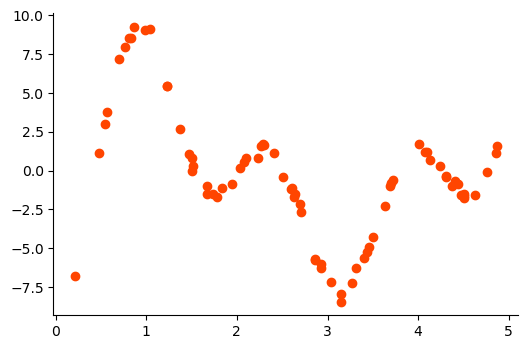

In [3]:
plt.figure(dpi=100)
plt.scatter(dat_x, dat_y, color='orangered')
sns.despine()

Now let's sample from our prior and just visualize what some generated curves look like.

In [4]:
tau = 2.
nx = 200
x = np.linspace(0, 5, nx)


def sample(k, n_func=5):    
    phi = np.zeros((nx, k+1))
    for ii in range(k+1):
        phi[:, ii] = np.cos(ii * x)
    
    draws = np.zeros((n_func, nx))
    for ff in range(n_func):
        coeffs = np.random.randn(k+1) * tau
        draws[ff, :] = phi @ coeffs
    
    plt.figure(dpi=100)
    plt.plot(x, draws[0, :], color='steelblue', alpha=0.5, label="Samples")
    plt.plot(x, draws[0:, :].T, color='steelblue', alpha=0.5)
    plt.scatter(dat_x, dat_y, color='orangered', label="Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(r"Sampled Models")
    sns.despine()
    plt.legend()
    plt.show()

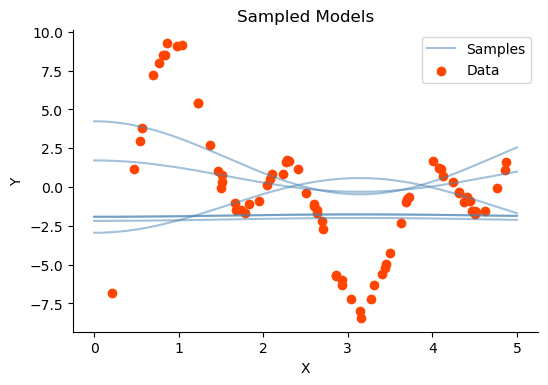

In [5]:
sample(1)

![goldilocks](goldilocks.png)

In [6]:
nx = 50
sig = 0.25
eps = np.random.RandomState(seed=1).randn(nx) * sig
x = np.linspace(-1, 1, nx)
test_x = np.linspace(-1, 1, 200)
# x = np.concatenate((x, np.random.rand(8) + 1.))
y = np.sign(x) + eps


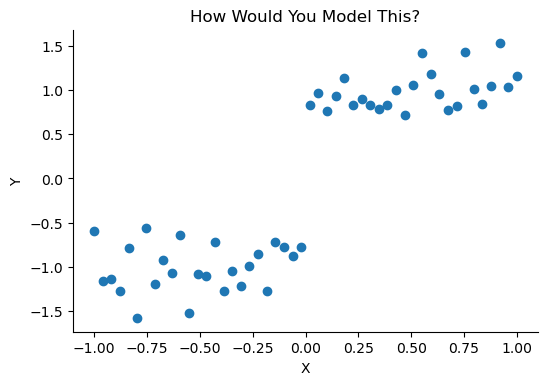

In [7]:
plt.figure(dpi=100)
plt.scatter(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("How Would You Model This?")
sns.despine()
plt.show()

What should $k$ be? 
$$
y = \sum_{i=0}^{k}w_i x^i + \epsilon
$$

In [8]:
def modeler(k):
    poly = PolynomialFeatures(k)

    phi_train = poly.fit_transform(x.reshape(-1, 1))
    phi_test = poly.fit_transform(test_x.reshape(-1, 1))
    
#     phi_train = np.zeros((len(x), k+1))
#     phi_test = np.zeros((len(test_x), k+1))
#     for ii in range(k+1):
#         phi_train[:, ii] = np.cos(ii * x)
#         phi_test[:, ii] = np.cos(ii * test_x)
    

    model = LinearRegression().fit(phi_train, y)
    preds = model.predict(phi_test)
    
    resid = y - model.predict(phi_train)
    sig_hat = resid.dot(resid)/(nx - k - 1)
    
    plt.figure(dpi=100)
    plt.plot(test_x, preds, color='steelblue', linewidth=2, label="Prediction")
    plt.fill_between(test_x, preds + 2*sig_hat, preds - 2*sig_hat, alpha=0.15)
    plt.scatter(x, y, color='orangered', label="Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Predictions With K = " + str(k))
    plt.legend()
    sns.despine()
#     plt.xlim(-2.5, 2.5)
#     plt.ylim(-2.5, 2.5)
    plt.show()

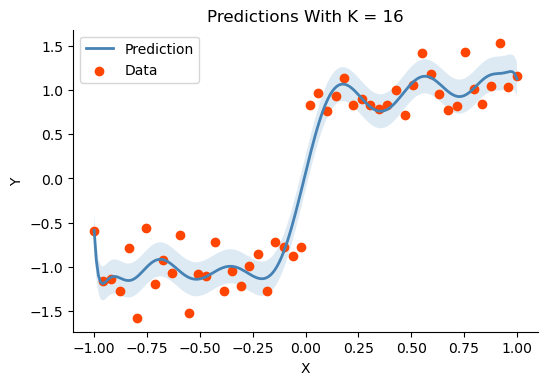

Object `poly.fit_transform` not found.


In [9]:
modeler(16)
?poly.fit_transform

## We Want to Formalize This Idea


The simplest model that explains the data will have the highest _marginal likelihood_ $p(y | \mathcal{M})$.

$$
p(y | \mathcal{M}) = \int_{{\bf w}}p(y | {\bf w}, \mathcal{M})p(\bf{w} | \mathcal{M}) d{\bf w}
$$


**Why is this expected?**

For our case we can compute the marginal (log) likelihood (MLL) explicitly

$$
p({\bf w} | \Lambda) = \mathcal{N}(0, \Lambda)
$$

$$
p({\bf y} | {\bf w}, {\bf x}) = \mathcal{N}(\Phi {\bf w}, \sigma^2)
$$

Then

$$
MLL = \frac{1}{2}\log(|\Lambda^{-1}|) + \frac{N}{2}\log\left(\frac{1}{\sigma^2}\right) - E(\mu_{post}) - \frac{1}{2}\log(|\Sigma_{post}^{-1}|) - \frac{N}{2}\log (2 \pi)
$$

with 
$$
E(\mu_{post}) = \frac{1}{2\sigma^2}||{\bf y} - \Phi \mu_{post}||^2 + \frac{1}{2}\mu_{post}\Lambda^{-1}\mu_{post}
$$
and
$$
\Sigma_{post} = \left(\Lambda^{-1} + \frac{1}{\sigma^2}\Phi^T\Phi\right)^{-1}
$$
and
$$
\mu_{post} = \frac{1}{\sigma^2}\Sigma_{post}\Phi^T y
$$

Start with 
$$
\Lambda = \tau^2 I
$$

In [10]:
tau = 10.

def compute_mll(k):
    poly = PolynomialFeatures(k)
    phi = poly.fit_transform(x.reshape(-1, 1))

    post_prec = phi.T @ phi/(sig**2) + 1/(tau**2) * np.identity(k+1)
    post_cov = np.linalg.inv(post_prec)
    post_mean = post_cov @ phi.T @ y/(sig**2)
    
    E_W = 1./(2.) * post_mean.T @ post_mean

    mll = (k+1)/2. * np.log(1./tau**2) - nx/2. * np.log(1./sig**2) - E_W -\
            1./2. * np.log(np.linalg.det(post_prec)) - nx/2. * np.log(np.pi * 2)
    
    return mll

In [11]:
probs = []
nmod = 30
for k in range(2, nmod):
    probs.append(compute_mll(k))
probs = np.array(probs)

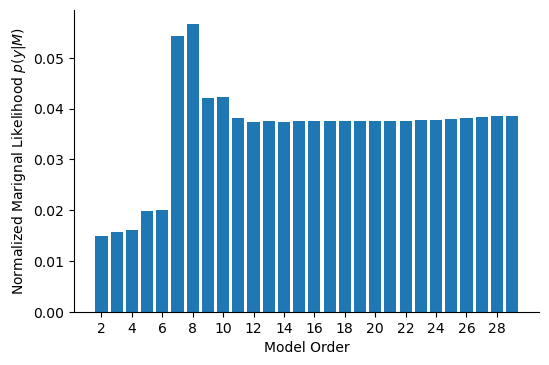

In [12]:
plt.figure(dpi=100)
plt.bar(np.arange(2, nmod), probs/(np.sum(probs)))
plt.xticks(np.arange(2, nmod)[::2])
plt.ylabel(r"Normalized Marignal Likelihood $p(y | M)$")
plt.xlabel("Model Order")
sns.despine()

## Can we remedy this Occam's hill behavior?

Can we set up a scenario where we can achieve the same performance using any sufficiently sized model? 

**Try with _anistropic_ prior.**

Up until now we've been using
$$
p(w_d) \sim N(0, \tau^2)
$$

what if we tried
$$
p(w_d) \sim N\left(0, \frac{\tau^2}{d^{2}}\right)
$$

**what's the intuition here?**

In [13]:
def compute_mll_scaled(k):
    poly = PolynomialFeatures(k)
    phi = poly.fit_transform(x.reshape(-1, 1))

    prior_var = np.diag([1.]+[d**(-2.) for d in range(1, k+1)]) * tau**2
    
    post_prec = phi.T @ phi/(sig**2) + np.linalg.inv(prior_var)
    post_cov = np.linalg.inv(post_prec)
    post_mean = post_cov @ phi.T @ y/(sig**2)

    mll = 1/2. * np.log(np.linalg.det(np.linalg.inv(prior_var))) - nx/2. * np.log(1./sig**2) - 1./2. * post_mean.T @ post_mean -\
            1./2. * np.log(np.linalg.det(post_prec)) - nx/2. * np.log(np.pi * 2)
    
    return mll

In [14]:
probs = []
nmod = 30
for k in range(2, nmod):
    probs.append(compute_mll_scaled(k))
probs = np.array(probs)

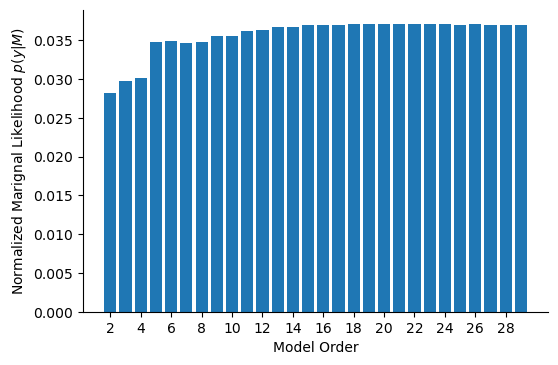

In [15]:
plt.figure(dpi=100)
plt.bar(np.arange(2, nmod), probs/(np.sum(probs)))
plt.xticks(np.arange(2,nmod)[::2])
plt.ylabel(r"Normalized Marignal Likelihood $p(y | M)$")
plt.xlabel("Model Order")
sns.despine()

## How Else Can We Use MLL?

**Adapted from Martin Krasser's Blog**

In [16]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var



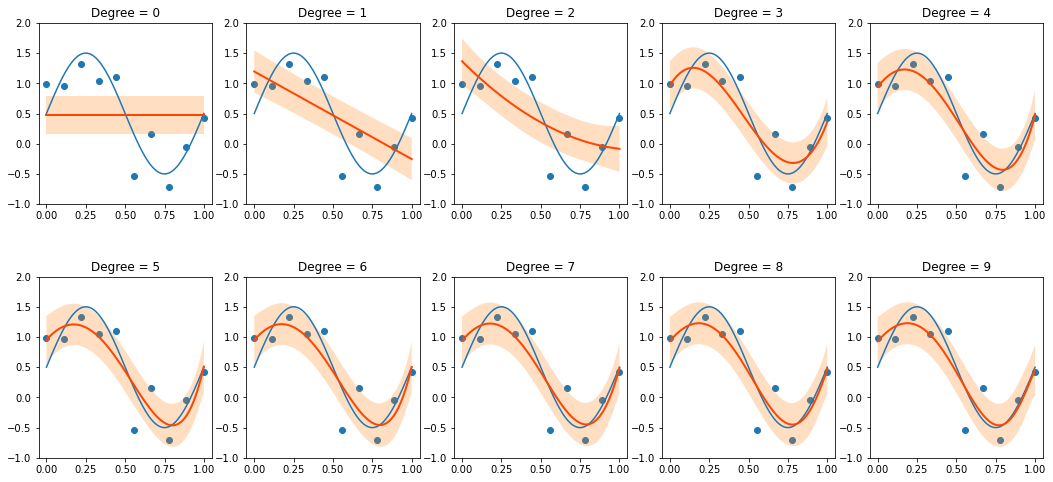

In [17]:
N = 10

beta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

X = np.linspace(0, 1, N).reshape(-1, 1)
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

y =  0.5 + np.sin(2 * np.pi * X) + np.sqrt(1./beta)*np.random.RandomState(seed=1).normal(size=X.shape)
y_true = 0.5 + np.sin(2 * np.pi * X_test)

plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    poly = PolynomialFeatures(d)
    Phi = poly.fit_transform(X)
    Phi_test = poly.fit_transform(X_test)
    up = d + 1
    m_N, S_N = posterior(Phi, y, alpha, beta)
    pred_y, pred_y_var = posterior_predictive(Phi_test, m_N, S_N, beta)

    plt.subplot(2, 5, up)
    plt.scatter(X,y)
    plt.plot(X_test, y_true, label=None)
    plt.plot(X_test, pred_y, color='orangered', linewidth=2.)
    plt.fill_between(X_test[:, 0], pred_y[:, 0] + np.sqrt(pred_y_var), pred_y[:, 0]-np.sqrt(pred_y_var),
                    alpha=0.25)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)

In [18]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape

    m_N, _, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)
    
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)
    
    score = M * np.log(alpha) + \
            N * np.log(beta) - \
            E_D - \
            E_W - \
            np.log(np.linalg.det(S_N_inv)) - \
            N * np.log(2 * np.pi)

    return 0.5 * score

In [19]:
y.shape

(10, 1)

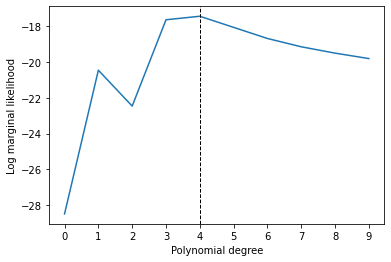

In [20]:
mlls = []

for d in degrees:
    poly = PolynomialFeatures(d)
    Phi = poly.fit_transform(X.reshape(-1, 1))
    mll = log_marginal_likelihood(Phi, y, alpha=alpha, beta=beta)
    mlls.append(mll)

degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood');

In [21]:
def fit(Phi, y, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    
    N, M = Phi.shape

    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha
        
        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(Phi, y, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N ** 2)

        beta_inv = 1 / (N - gamma) * np.sum((y - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

In [22]:
k=4
poly = PolynomialFeatures(k)
phi = poly.fit_transform(X.reshape(-1, 1))
phi_test = poly.fit_transform(X_test.reshape(-1, 1))
alpha, beta, m_N, S_N = fit(phi, y, rtol=1e-5, verbose=True)

Convergence after 23 iterations.


In [23]:
y_pred, y_pred_var = posterior_predictive(phi_test, m_N, S_N, beta)

(-1.0, 2.0)

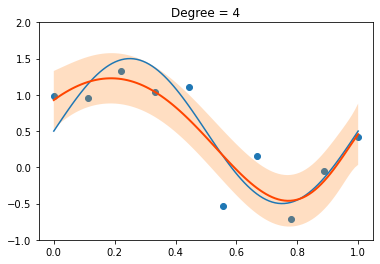

In [24]:
plt.scatter(X,y)
plt.plot(X_test, y_true, label=None)
plt.plot(X_test, pred_y, color='orangered', linewidth=2.)
plt.fill_between(X_test[:, 0], pred_y[:, 0] + np.sqrt(pred_y_var), pred_y[:, 0]-np.sqrt(pred_y_var),
                alpha=0.25)
plt.title(f'Degree = {k}')
plt.ylim(-1.0, 2.0)